## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymysql
import pymysql.cursors
import seaborn as sns
from scipy import stats

sns.set_style('darkgrid')
sns.set_theme(palette='ocean_r')
pd.set_option('display.max_colwidth', None)

## Data loading

Connect to database

In [2]:
conn = pymysql.connect(user='root',
                       password='rootpass',
                       host='database',
                       port=3306,
                       database='scraper',
                       charset='utf8',
                       cursorclass=pymysql.cursors.DictCursor)

Read the data and store in dataframe

In [3]:
with conn.cursor() as cursor:
    cursor.execute('SELECT * FROM rentals;')
    data = cursor.fetchall()

df = pd.DataFrame(data)

Add `has_balcony_and_terrace` field

In [4]:
df.loc[:, 'has_balcony_and_terrace'] = df['has_balcony'] & df['has_terrace']

Add `balcony_and_terrace` column

In [5]:
def balcony_and_terrace(row):
    if row['has_balcony_and_terrace'] == 1: return 'balcony_and_terrace'
    if row['has_balcony'] == 1: return 'balcony'
    if row['has_terrace'] == 1: return 'terrace'
    return 'none'

df.loc[:, 'balcony_and_terrace'] = df.apply(balcony_and_terrace, axis=1)

## Treating outliers

### Price

By looking at the `price` statistics we can clearly see there are some outliers.

In [6]:
df['price'].describe()

count       605.000000
mean      20859.223140
std       11189.737266
min        2500.000000
25%       15650.000000
50%       17500.000000
75%       23000.000000
max      155000.000000
Name: price, dtype: float64

By looking at the distribution we can see there is some **positive skew**.

Text(0.5, 0, 'Price')

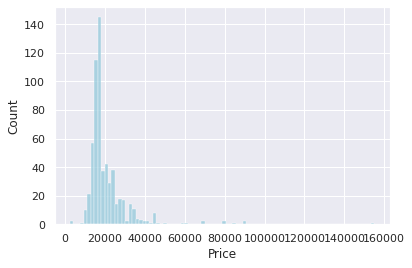

In [7]:
_, ax = plt.subplots()

sns.histplot(data=df, x='price')

ax.set_xlabel('Price')

We can transform the data with a **Box-Cox transform** in order to shape it as closely to normal as possible.

Text(0.5, 0, 'Price (log)')

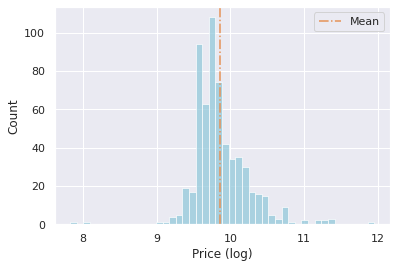

In [8]:
price = df['price']
transform = stats.boxcox(price, 0)

_, ax = plt.subplots()
sns.histplot(transform, ax=ax)
ax.axvline(transform.mean(), ls='-.', label='Mean', color='#E59155')
ax.legend()
ax.set_xlabel('Price (log)')

Now we can apply basic statistics to remove outliers by using the `z-score`. This distribution seems much more reasonable.

Text(0.5, 0, 'Price')

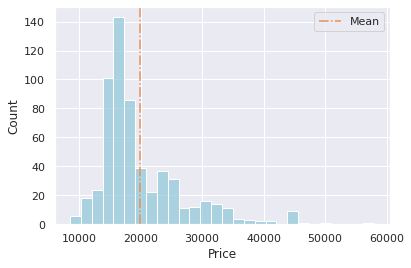

In [9]:
z = (transform - transform.mean()) / transform.std()
mask = (z >= -3) & (z <= 3)
price_without_outliers = price[mask]

_, ax = plt.subplots()
sns.histplot(price_without_outliers, ax=ax)
ax.axvline(price_without_outliers.mean(), ls='-.', label='Mean', color='#E59155')
ax.legend()
ax.set_xlabel('Price')

Finally, drop them from the original dataset

In [10]:
df = df.loc[mask].copy()

### Expenses

We can do the same for `expenses`, as wee see some outliers in the statistics.

In [11]:
df['expenses'].describe()

count      497.000000
mean      4705.845070
std       1973.739773
min          4.000000
25%       3500.000000
50%       4277.000000
75%       5500.000000
max      16000.000000
Name: expenses, dtype: float64

Distribution

Text(0.5, 0, 'Expenses')

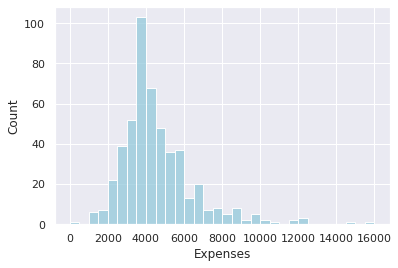

In [12]:
_, ax = plt.subplots()

sns.histplot(data=df, x='expenses')

ax.set_xlabel('Expenses')

By looking at the distribution, we can see that there is actually 1 unique data point that seems to be an outlier. For simplicity, we'll remove this unique point.

In [13]:
mask = df['expenses'] != 4
df = df.loc[mask].copy()

We can see the distribution makes much more sense now

Text(0.5, 0, 'Expenses')

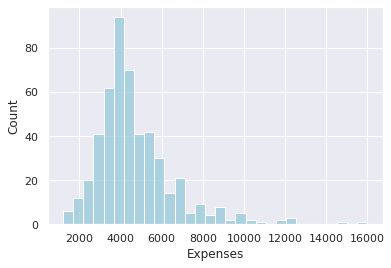

In [14]:
_, ax = plt.subplots()

sns.histplot(data=df, x='expenses')

ax.set_xlabel('Expenses')

### Price and expenses

Let's do a sanity check to see if all `expense` are lower than their `price`s

In [15]:
df.query('expenses >= price')

,title,description,extras,price,expenses,location,link,total_surface,covered_surface,rooms,has_balcony,has_terrace,has_garage,is_studio_apartment,has_balcony_and_terrace,balcony_and_terrace


And some plotting just to be sure

(0.0, 17000.0)

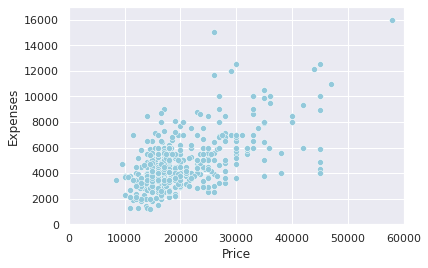

In [16]:
_, ax = plt.subplots()

sns.scatterplot(data=df, x='price', y='expenses', ax=ax)

ax.set_xlabel('Price')
ax.set_ylabel('Expenses')

ax.set_xlim(0, 60000)
ax.set_ylim(0, 17000)

### Surfaces

Since both `total_surface` and `covered_surface` are pretty similar, we can analyse both at the same time. To get some notion, we can plot both:

Text(0, 0.5, 'Total surface')

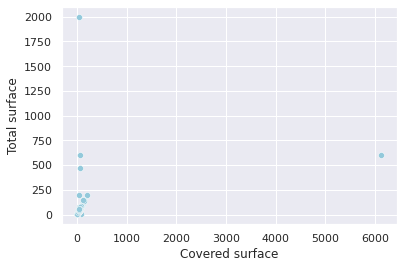

In [17]:
_, ax = plt.subplots()

sns.scatterplot(
    data=df,
    x='covered_surface',
    y='total_surface',
    palette='tab20',
    ax=ax
)

ax.set_xlabel('Covered surface')
ax.set_ylabel('Total surface')

So, from this plot we can see some weird surfaces:
- A 500 `total_surface`
- A value of 2000 for a `total_surface`
- A value of over 6000 for a `covered_surface`
- Values of 1 for both `covered_surface` and `total_surface`

> _manual reviewing done here, skipped for simplicity..._

In [18]:
df.loc[9, 'total_surface'] = df.loc[9, 'covered_surface']
df.loc[598, 'total_surface'] = df.loc[598, 'covered_surface']
df.loc[327, 'total_surface'] = df.loc[327, 'covered_surface']
df.loc[393, 'total_surface'] = df.loc[393, 'covered_surface']
mask = df['total_surface'] < df['covered_surface']
df.loc[mask, 'total_surface'] = df.loc[mask, 'covered_surface']
df = df.query('total_surface >= 17 and covered_surface < 6000').copy()

Let's plot again to check the values

Text(0, 0.5, 'Total surface')

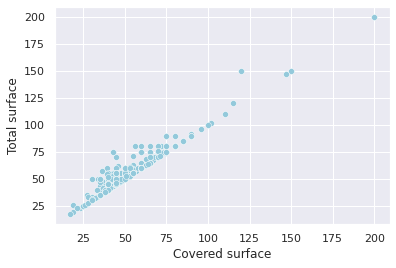

In [19]:
_, ax = plt.subplots()

sns.scatterplot(
    data=df,
    x='covered_surface',
    y='total_surface',
    palette='tab20',
    ax=ax
)

ax.set_xlabel('Covered surface')
ax.set_ylabel('Total surface')

### Rooms

Lastly, let's check the `rooms`. First, some statistics

In [20]:
pd.Categorical(df['rooms']).describe()

,counts,freqs
categories,,
1.0,84,0.175000
2.0,233,0.485417
3.0,105,0.218750
4.0,24,0.050000
5.0,10,0.020833
6.0,2,0.004167
8.0,1,0.002083
NaN,21,0.043750


Let's now check agains the `total_surface`, assuming the more rooms, the higher the surface

Text(0, 0.5, 'Covered surface')

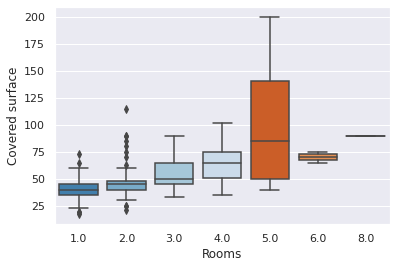

In [21]:
_, ax = plt.subplots()

sns.boxplot(data=df, x='rooms', y='covered_surface', palette='tab20c', ax=ax)
ax.set_xlabel('Rooms')
ax.set_ylabel('Covered surface')

There seems to be something strange with some 5 `room` apartments.

> _Did some manual checking and everything seemed ok..._

## Exporting to parquet

After cleaning the data, we export it to a parquet file.

In [22]:
df.to_parquet('clean_data.parquet', index=False)